In [1]:
pip install matplotlib networkx pandas scipy geopandas descartes

Note: you may need to restart the kernel to use updated packages.


In [2]:
import json
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, Polygon
from pyproj import CRS

# Load data from 'pcm-dpc/COVID-19 Italia' GitHub repository

In [3]:
with open('./dati-json/dpc-covid19-ita-province.json') as f:
    covid19_provinces_data = json.load(f)

with open('./dati-json/dpc-covid19-ita-regioni.json') as f:
    covid19_regions_data = json.load(f)

# Provinces's analysis
Here we start grouping the information by provinces

In [4]:
data = []
for province in covid19_provinces_data:
    province_denomination = province['sigla_provincia']
    province_date = province['data']
    # Es. ('FI', '2020-02-24T...', all data on that row)
    # the first 2 values will be used as key
    data.append([province_denomination, province_date, province.values()]) 

# Sort according to the date
data = sorted(data, key=lambda x: x[0])
# Prepare data for the DataFrame
index = []
province_info = []
for province in data:
    index.append([province[0], province[1]]) # (Name, date)
    province_info.append(province[2]) # (codice_regione, codice_provincia, ...)
index = pd.MultiIndex.from_tuples(index) # Index ranking: 1° City's name, 2° date
# Create finally the DataFrame
data = pd.DataFrame(province_info, index=index, columns=covid19_provinces_data[0].keys())
# and drop some usless columns
density_data = data.drop(columns=['data', 'codice_regione', 'denominazione_regione', 'stato', 'codice_provincia', 'sigla_provincia', 'note_it', 'note_en'])
density_data = density_data[density_data.denominazione_provincia != "In fase di definizione/aggiornamento"]
dati = density_data.drop(columns=['long', 'lat'])
density_data.head()

denominazione_provincia        lat       long  \
AG 2020-02-24T18:00:00               Agrigento  37.309711  13.584575   
   2020-02-25T18:00:00               Agrigento  37.309711  13.584575   
   2020-02-26T18:00:00               Agrigento  37.309711  13.584575   
   2020-02-27T18:00:00               Agrigento  37.309711  13.584575   
   2020-02-28T18:00:00               Agrigento  37.309711  13.584575   

                        totale_casi  
AG 2020-02-24T18:00:00            0  
   2020-02-25T18:00:00            0  
   2020-02-26T18:00:00            0  
   2020-02-27T18:00:00            0  
   2020-02-28T18:00:00            0

# Map overview
#### We select 3 different days

In [5]:
days_df = []
days = density_data.index.unique(level=1)
days = list( days[i] for i in [0, len(days)//(20), len(days)//(5), len(days)-1] ) # Select 3 different days
for i, day in enumerate(range(len(days))):
    interested_rows = []
    for sigla_pv in density_data.index.unique(level=0):
        interested_rows.append(density_data.loc[sigla_pv].loc[days[day]])
    days_df.append(pd.DataFrame(interested_rows))
    days_df[i] = days_df[i].set_index(["denominazione_provincia", 'lat', 'long'])
total_cases_df = pd.concat(days_df, axis=1)
columns = pd.MultiIndex.from_product([['Total_cases'], days])
total_cases_df.columns = columns
total_cases_df.head()

Total_cases  \
                                            2020-02-24T18:00:00   
denominazione_provincia lat       long                            
Agrigento               37.309711 13.584575                   0   
Alessandria             44.912974 8.615401                    0   
Ancona                  43.616760 13.518875                   0   
Aosta                   45.737503 7.320149                    0   
Ascoli Piceno           42.853223 13.576911                   0   

                                                                 \
                                            2020-02-28T18:00:00   
denominazione_provincia lat       long                            
Agrigento               37.309711 13.584575                   0   
Alessandria             44.912974 8.615401                    0   
Ancona                  43.616760 13.518875                   0   
Aosta                   45.737503 7.320149                    0   
Ascoli Piceno           42.853223 13.576911                   0   

                                                                 \
                                            2020-03-12T17:00:00   
denominazione_provincia lat       long                            
Agrigento               37.309711 13.584575                  17   
Alessandria             44.912974 8.615401                  132   
Ancona                  43.616760 13.518875                 142   
Aosta                   45.737503 7.320149                   27   
Ascoli Piceno           42.853223 13.576911                   1   

                                                                 
                                            2020-05-19T17:00:00  
denominazione_provincia lat       long                           
Agrigento               37.309711 13.584575                 141  
Alessandria             44.912974 8.615401                 3807  
Ancona                  43.616760 13.518875                1860  
Aosta                   45.737503 7.320149                 1175  
Ascoli Piceno           42.853223 13.576911                 290

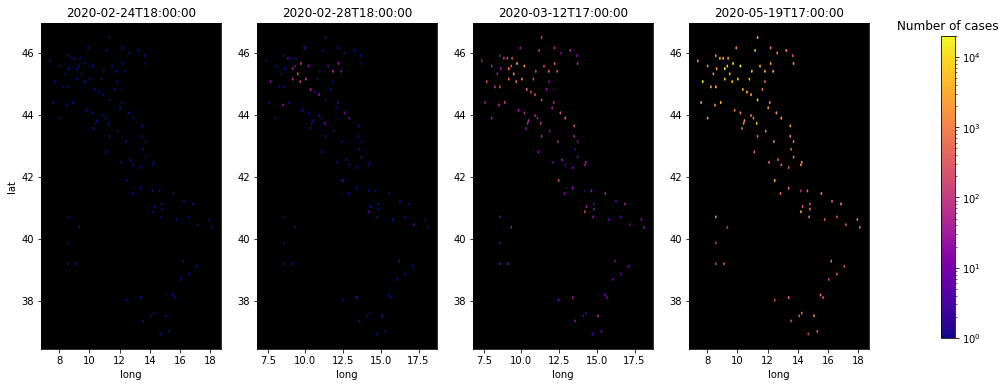

In [6]:
from matplotlib.colors import LinearSegmentedColormap

grid_size = (1,len(days))
fig, axes = plt.subplots(nrows=grid_size[0], ncols=grid_size[1], figsize=(20,6))
x = total_cases_df.index.unique(level=2) # longitude
y = total_cases_df.index.unique(level=1) # latitude
for i,day in enumerate(days):
    z = total_cases_df['Total_cases'][day]    
    axes[i].set_facecolor('black')    
    im = axes[i].hexbin(x,y, C=z, bins='log', edgecolors=None, cmap='plasma', vmin=1., vmax=20000)
    axes[i].set_title(day)
    axes[i].set_xlabel("long")

# Color bar
fig.subplots_adjust(right=0.7)
cbar_ax = fig.add_axes([0.75, 0.15, 0.01, 0.7])
cbar_ax.set_title('Number of cases')
fig.colorbar(im, cax=cbar_ax)
    
    
axes[0].set_ylabel("lat")
plt.show()

### Distribution of cities with total number of cases above a threshold

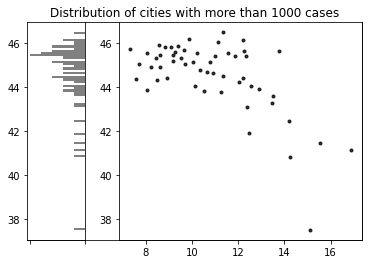

In [7]:
threshold = 1000
cases_threshold = total_cases_df['Total_cases'][days[-1]] >= threshold
threshold_cases_df = total_cases_df[cases_threshold]
x = threshold_cases_df.index.unique(level=2) # longitude
y = threshold_cases_df.index.unique(level=1) # latitude

# Set up the axes with gridspec
fig = plt.figure(figsize=(6, 4), constrained_layout=False)
plt.title("Distribution of cities with more than "+str(threshold)+" cases")
grid = plt.GridSpec(4, 4, hspace=0.6, wspace=0.6)
plt.xticks([])
plt.yticks([])

y_hist = fig.add_subplot(grid[:, 0], xticklabels=[])
main_ax = fig.add_subplot(grid[:, 1:], sharey=y_hist)
# scatter points on the main axes
main_ax.plot(x, y, 'ok', markersize=3, alpha=0.8)
# histogram on the attached axes
y_hist.hist(y, 90, histtype='stepfilled', orientation='horizontal', color='gray')
y_hist.invert_xaxis()

### We extract the total number of cases at the end of the month for each province

In [8]:
# Get the provinces name (Sigle)
provinces = dati.index.unique(level=0)
# Create a DataFrame with total cases per month for each province
cases_per_month = {}

for province in provinces: 
    province_info = dati.loc[province]
    # The 'groupby(province_info.data.str[:7]' is used to group the rows according to the month
    # The [:7] is used to slice the first 7 letters of the 'data' column
    # 2020-05-15T17:00:00 ---> 2020-05
    # And finally sum the 'totale_casi' values grouped by month for each province
    cases_per_month[province] = pd.Series(province_info.groupby(province_info.index.str[:7])['totale_casi'].tail(1))

# Create the DataFrame using the Series defined in the for loop
cpm = pd.DataFrame(cases_per_month)
cpm = cpm.T # For a better view
#cpm = cpm.drop(cpm.index[0]) # Drop data without 'denominazione_provincia' info
cpm.columns = [i[0:7] for i in cpm.columns] # Rename the columns dropping away the year
cpm = cpm.drop(columns=['2020-02'])
cpm.head()

,2020-03,2020-04,2020-05
AG,94,135,141
AL,1317,3417,3807
AN,1116,1810,1860
AO,628,1128,1175
AP,222,281,290


### Make a plot for the cities with the highest cases (se metto i bar plot insieme ai pie plot esplodono i grafici, non so perchè, devo ancora rivedere questo punto)

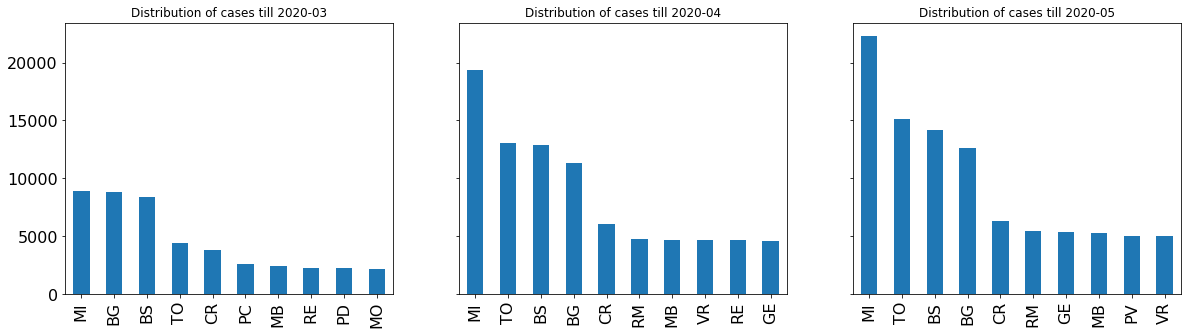

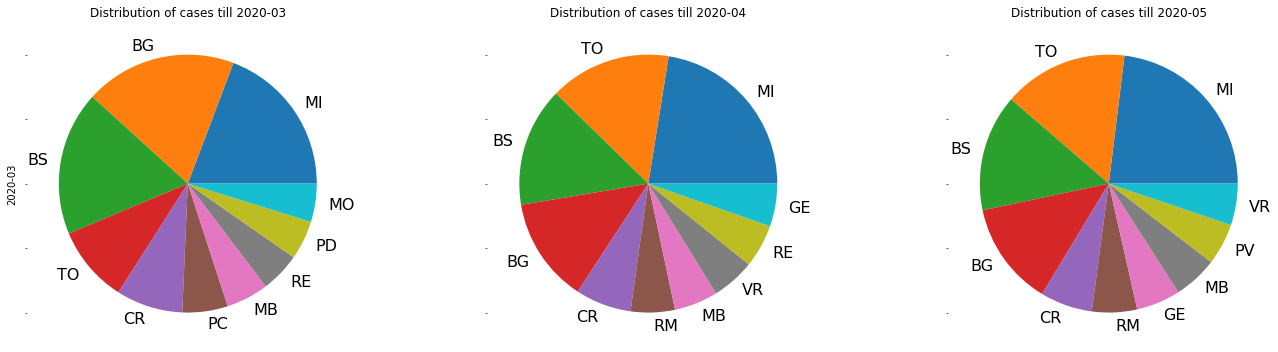

In [9]:
grid_size = (1,3) # For the 4 month considered
colors = ['g', 'r', 'b', 'y']

for plot_type in ['bar', 'pie']:
    fig, axes = plt.subplots(nrows=grid_size[0], ncols=grid_size[1], sharey=True, figsize=(20,5))
    cities_with_worst_cases = [] # Store the name of the cities with the worst cases

    month = 0
    w_cases_pm = [] # worst cases per month -> it will be used for the 'Total number of cases' plot
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            # Cities twith the worst cases in the current month
            worst_cases = cpm.nlargest(10, cpm.columns[month])[cpm.columns[month]] # Top 10
            w_cases_pm.append(worst_cases)
            worst_cases.plot(ax=axes[month], kind=plot_type, 
                             legend=False,
                             fontsize=16)
            axes[month].set_title('Distribution of cases till '+cpm.columns[month])
            cities_with_worst_cases.append(worst_cases)
            month += 1
        
fig.tight_layout()

### Total cases day by day for cities with the highest cases

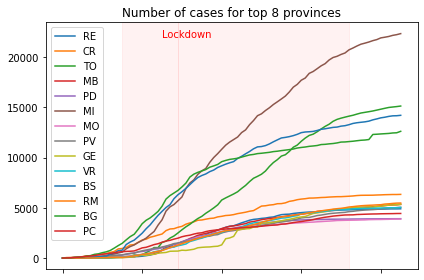

In [10]:
# Create a set of the cities with the highest cases 
interested_city = list(set([item for sublist in [list(city.index) for city in cities_with_worst_cases] for item in sublist]))


# Collect information about these cities day by day
for i in range(len(interested_city)):
    dati.loc[interested_city[i]]['totale_casi'].plot(
        kind='line', 
        label=interested_city[i], 
        title="Number of cases for top 8 provinces").set_xticklabels([])    

plt.text(25, 22000, "Lockdown", color="r")
plt.axvspan(15, 29, color='red', alpha=0.05)
plt.axvspan(29, 72, color='red', alpha=0.05)
plt.tight_layout()
plt.legend()

# Regions's analysis

#### First we group the data by the regions

In [11]:
data = []
for region in covid19_regions_data:
    region_denomination = region['denominazione_regione']
    region_date = region['data']
    data.append([region_denomination, region_date, region.values()]) 

# Sort according to the date
data = sorted(data, key=lambda x: x[0])
# Prepare data for the DataFrame
index = []
region_info = []
for region in data:
    index.append([region[0], region[1]]) # (Name, date)
    region_info.append(region[2]) # (codice_regione, codice_provincia, ...)
index = pd.MultiIndex.from_tuples(index) # Index ranking: 1° City's name, 2° date
# Create finally the DataFrame
regions_data_frame = pd.DataFrame(region_info, index=index, columns=covid19_regions_data[0].keys()).fillna(0)
regions_data_frame = regions_data_frame.drop(columns=['data', 'codice_regione', 'denominazione_regione', 'stato', 'note_it', 'note_en', 'lat', 'long'])
regions_data_frame.tail()

ricoverati_con_sintomi  terapia_intensiva  \
Veneto 2020-05-15T17:00:00                     311                 24   
       2020-05-16T17:00:00                     290                 20   
       2020-05-17T17:00:00                     273                 22   
       2020-05-18T17:00:00                     263                 22   
       2020-05-19T17:00:00                     259                 18   

                            totale_ospedalizzati  isolamento_domiciliare  \
Veneto 2020-05-15T17:00:00                   335                    4104   
       2020-05-16T17:00:00                   310                    3852   
       2020-05-17T17:00:00                   295                    3746   
       2020-05-18T17:00:00                   285                    3719   
       2020-05-19T17:00:00                   277                    3477   

                            totale_positivi  variazione_totale_positivi  \
Veneto 2020-05-15T17:00:00             4439                        -279   
       2020-05-16T17:00:00             4162                        -277   
       2020-05-17T17:00:00             4041                        -121   
       2020-05-18T17:00:00             4004                         -37   
       2020-05-19T17:00:00             3754                        -250   

                            nuovi_positivi  dimessi_guariti  deceduti  \
Veneto 2020-05-15T17:00:00              44            12688      1762   
       2020-05-16T17:00:00              39            12983      1783   
       2020-05-17T17:00:00              13            13106      1794   
       2020-05-18T17:00:00               9            13143      1803   
       2020-05-19T17:00:00              47            13423      1820   

                            totale_casi  tamponi  casi_testati  
Veneto 2020-05-15T17:00:00        18889   484639      264091.0  
       2020-05-16T17:00:00        18928   497045      269003.0  
       2020-05-17T17:00:00        18941   506588      272938.0  
       2020-05-18T17:00:00        18950   513021      275851.0  
       2020-05-19T17:00:00        18997   523800      280629.0

 #### Then we show all the information for few regions

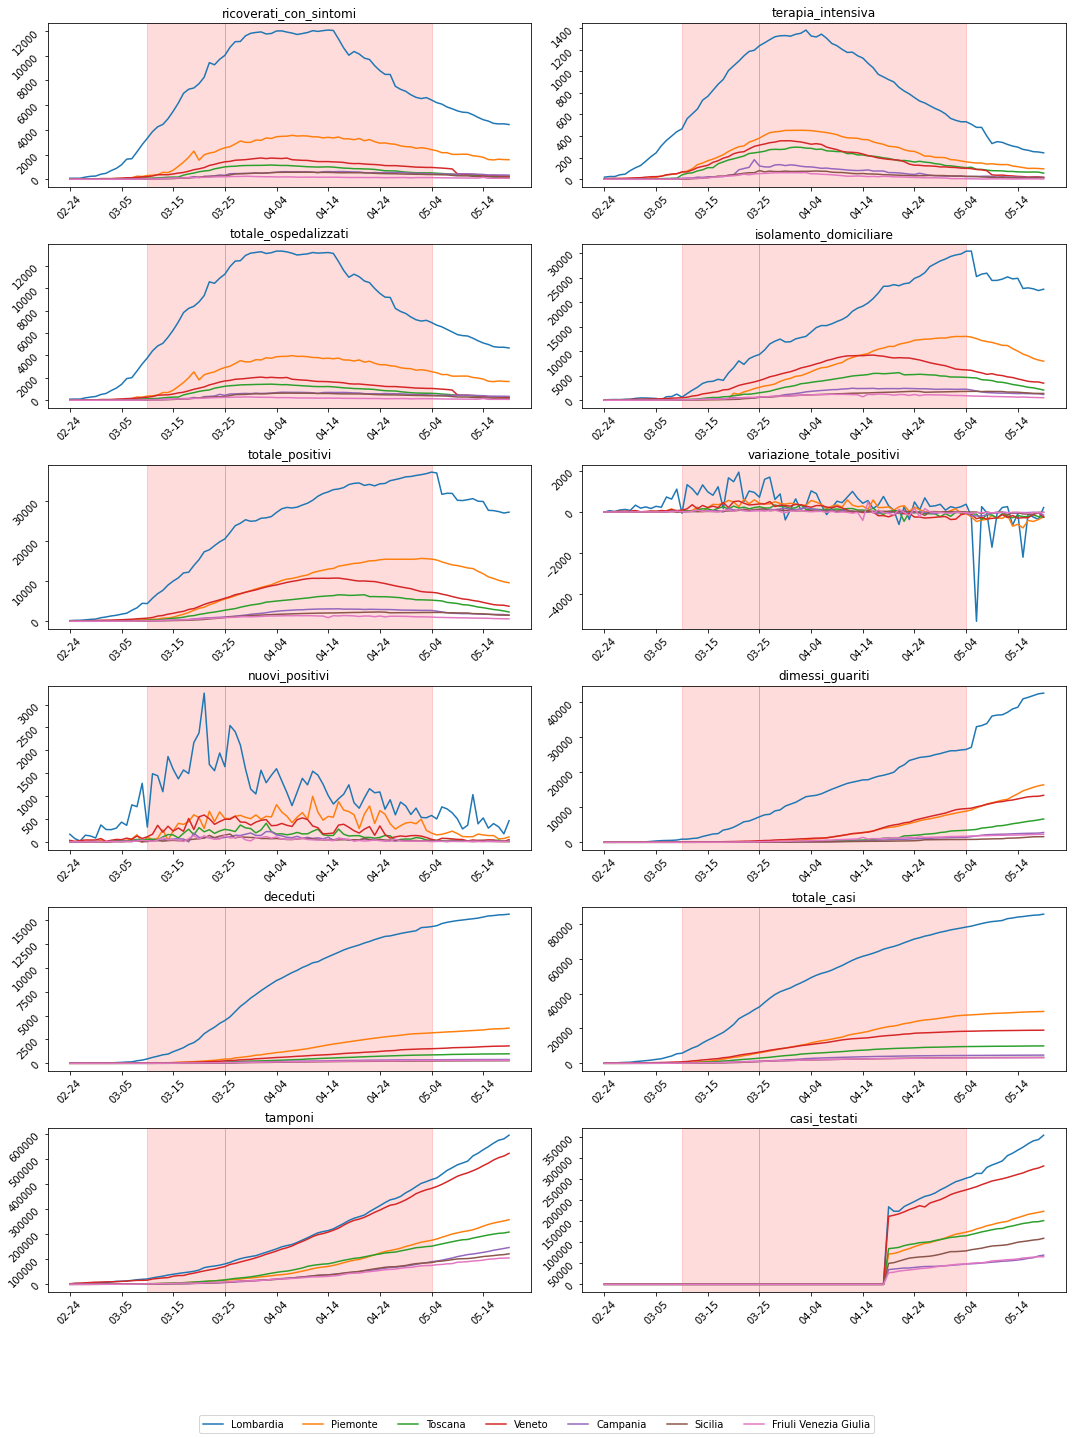

In [12]:
regions_considered = ['Lombardia', 'Piemonte', 'Toscana', 'Veneto', 'Campania', 'Sicilia', 'Friuli Venezia Giulia']
grid_size = (6, 2) # (#regions x #columns's info)
fig, axes = plt.subplots(nrows=grid_size[0], ncols=grid_size[1], sharex=False, figsize=(15,20))

i = 0
r, c = (0,0)
x_labels = regions_data_frame.index.unique(level=1)
x_labels = [elem[5:10] for elem in x_labels] # take only the month and the day, cut off the rest
for column_info in regions_data_frame.columns:
    for region in regions_considered:
        regions_data_frame.loc[region][column_info].plot(ax=axes[r,c], kind='line', title=column_info)
        axes[r,c].axvspan(15, 30, color='red', alpha=0.02) # Start of lockdown
        axes[r,c].axvspan(30, 70, color='red', alpha=0.02) # Lockdown's effects after 14 days
        # Calculate the xlabels for each subplot
        plt.sca(axes[r, c])
        plt.xticks(range(len(x_labels)), x_labels)
        xticks = axes[r,c].xaxis.get_major_ticks()
        for i in range(len(xticks)):
            if i % 10 != 0:
                xticks[i].set_visible(False)
        axes[r,c].tick_params(labelrotation=45)
        
    # Calculate the next subplot's indexes
    c = (c+1)%grid_size[1]
    if c == 0:
        r+=1

plt.tight_layout()
fig.subplots_adjust(bottom=0.1)
fig.legend(labels=regions_considered, loc="lower center", ncol=len(regions_considered))

In [13]:
# set the filepath and load in a shapefile
fp = "shape-italy/ITA_adm1.shp"
map_df = gpd.read_file(fp)
# check data type so we can see that this is not a normal dataframe, but a GEOdataframe
map_df.drop(columns=["VARNAME_1", "TYPE_1", "ID_1", "ENGTYPE_1", "NL_NAME_1", "ISO", "ID_0", "NAME_0"])

,NAME_1,geometry
0,Abruzzo,"POLYGON ((13.91542 42.89561, 13.91542 42.89542..."
1,Apulia,"MULTIPOLYGON (((17.94931 40.05375, 17.94931 40..."
2,Basilicata,"MULTIPOLYGON (((15.71736 39.96792, 15.71736 39..."
3,Calabria,"MULTIPOLYGON (((15.80208 39.70014, 15.80208 39..."
4,Campania,"MULTIPOLYGON (((14.25264 40.54153, 14.25264 40..."
5,Emilia-Romagna,"MULTIPOLYGON (((12.40590 43.89975, 12.40600 43..."
6,Friuli-Venezia Giulia,"MULTIPOLYGON (((13.31625 45.69347, 13.31625 45..."
7,Lazio,"MULTIPOLYGON (((13.45514 40.79264, 13.45514 40..."
8,Liguria,"MULTIPOLYGON (((8.22597 44.02736, 8.22597 44.0..."
9,Lombardia,"MULTIPOLYGON (((8.81457 45.01818, 8.81401 45.0..."


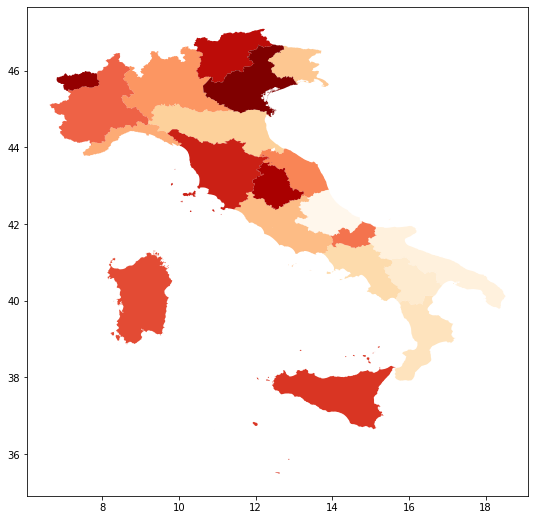

In [14]:
plt.rcParams['figure.figsize'] = [9, 9] #height, width
plt.rcParams['patch.facecolor'] = 'black'
map_df.plot(cmap='OrRd')

In [15]:
# loding into a DataFrame the provinces data as is
province_data = pd.DataFrame(covid19_provinces_data)

# performing the few modifications listed above
refined_province_data = province_data[province_data.denominazione_provincia!= "In fase di definizione/aggiornamento"].drop(columns=["note_it", "note_en", "codice_provincia", "codice_regione", "stato"])

# for each date value is cropped the ending, leaving only the structure year-month-day.
# E.g. from the original date '2020-02-24T18:00:00' the result is simply '2020-02-24'
refined_province_data['data'] = refined_province_data['data'].map(lambda a: a[:10])

# prendiamo la tabella originale e impostiamo crs, definisci cos'è coordinate reference system
crs = CRS("epsg:4326")
refined_province_data.head()

,data,denominazione_regione,denominazione_provincia,sigla_provincia,lat,long,totale_casi
0,2020-02-24,Abruzzo,Chieti,CH,42.351032,14.167546,0
1,2020-02-24,Abruzzo,L'Aquila,AQ,42.351222,13.398438,0
2,2020-02-24,Abruzzo,Pescara,PE,42.464584,14.213648,0
3,2020-02-24,Abruzzo,Teramo,TE,42.658918,13.704400,0
5,2020-02-24,Basilicata,Matera,MT,40.667512,16.597924,0


In [16]:
# extract latitude and longitude data from the last date available, along with the total cases (that are at its max)
# lasciata la colonna data in vista di uno stesso calcolo ma diviso per mesi e non prendendo il numero massimo di casi
provinces_data_per_latitude_longitude = refined_province_data.drop(columns=["denominazione_regione", "sigla_provincia"]).groupby(["denominazione_provincia"]).max()
provinces_data_per_latitude_longitude.head()

,data,lat,long,totale_casi
denominazione_provincia,,,,
Agrigento,2020-05-19,37.309711,13.584575,141
Alessandria,2020-05-19,44.912974,8.615401,3807
Ancona,2020-05-19,43.616760,13.518875,1867
Aosta,2020-05-19,45.737503,7.320149,1175
Arezzo,2020-05-19,43.466428,11.882288,674


In [17]:
geometry = [Point(xy) for xy in zip(provinces_data_per_latitude_longitude['long'], provinces_data_per_latitude_longitude['lat'], provinces_data_per_latitude_longitude['totale_casi'])]
# plotting some points
geometry[:3]

In [18]:
# now we can create our GeoDataFrame using this points
geo_df= gpd.GeoDataFrame(provinces_data_per_latitude_longitude, crs = crs, geometry = geometry)
geo_df.head()

,data,lat,long,totale_casi,geometry
denominazione_provincia,,,,,
Agrigento,2020-05-19,37.309711,13.584575,141,POINT Z (13.58457 37.30971 141.00000)
Alessandria,2020-05-19,44.912974,8.615401,3807,POINT Z (8.61540 44.91297 3807.00000)
Ancona,2020-05-19,43.616760,13.518875,1867,POINT Z (13.51888 43.61676 1867.00000)
Aosta,2020-05-19,45.737503,7.320149,1175,POINT Z (7.32015 45.73750 1175.00000)
Arezzo,2020-05-19,43.466428,11.882288,674,POINT Z (11.88229 43.46643 674.00000)


In [22]:
### ABDULLAH ###

# loding into a DataFrame the provinces data as is
regions_data = pd.DataFrame(covid19_regions_data)

# for each date value is cropped the ending, leaving only the structure year-month-day.
# E.g. from the original date '2020-02-24T18:00:00' the result is simply '2020-02-24'
regions_data['data'] = regions_data['data'].map(lambda a: a[:10])
regions_data = regions_data.drop(columns=['stato','codice_regione','note_it','note_en'])
# In questa riga vengono presi i dati della data desiderata
regions_data_r = regions_data['data'] == '2020-05-19' # select the desired date
regions_data = regions_data[regions_data_r].set_index('denominazione_regione') # reset the index
trento_cases = regions_data.loc['P.A. Trento']['totale_casi'] # We will combine total cases of Trento and Bolzano
regions_data = regions_data.drop(['P.A. Trento'])
regions_data.head()

,data,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,casi_testati
denominazione_regione,,,,,,,,,,,,,,,
Abruzzo,2020-05-19,42.351222,13.398438,188,6,194,1195,1389,-24,4,1419,389,3197,58945,41162.0
Basilicata,2020-05-19,40.639471,15.805148,26,1,27,57,84,-9,1,282,27,393,23347,22767.0
P.A. Bolzano,2020-05-19,46.499335,11.356624,46,6,52,256,308,1,5,1988,291,2587,55526,25263.0
Calabria,2020-05-19,38.905976,16.594402,50,2,52,330,382,-19,2,676,95,1153,57310,55270.0
Campania,2020-05-19,40.839566,14.250850,330,17,347,1171,1518,-155,12,2790,399,4707,147225,69264.0


In [23]:
### ABDULLAH ###


# We have different region's name (and order) in the map_df and regions_data DataFrame. 
# So we need to shift and combine some values manually
totale_casi = list(regions_data['totale_casi'])
totale_casi.insert(1, totale_casi.pop(13))
totale_casi.insert(16, totale_casi.pop(3))
totale_casi[16] += trento_cases # Total cases of Trento + Bolzano 
map_df['totale_casi'] = totale_casi # Add 'toale_casi' column to the GeoDataFrame map_df
map_df.head()

,ID_0,ISO,NAME_0,ID_1,NAME_1,TYPE_1,ENGTYPE_1,NL_NAME_1,VARNAME_1,geometry,totale_casi
0,112,ITA,Italy,1,Abruzzo,Regione,Region,None,Abruzos|Abruzzen|Abruzzes|Abruzzi,"POLYGON ((13.91542 42.89561, 13.91542 42.89542...",3197
1,112,ITA,Italy,2,Apulia,Regione,Region,None,Apulien|Pouilles|Pouille|Puglia|Puglie,"MULTIPOLYGON (((17.94931 40.05375, 17.94931 40...",4396
2,112,ITA,Italy,3,Basilicata,Regione,Region,None,Basilicate|Lucania,"MULTIPOLYGON (((15.71736 39.96792, 15.71736 39...",393
3,112,ITA,Italy,4,Calabria,Regione,Region,None,Calabre|Calabrie|Kalabrien,"MULTIPOLYGON (((15.80208 39.70014, 15.80208 39...",1153
4,112,ITA,Italy,5,Campania,Regione,Region,None,Campanha|Campanie|Kampanien,"MULTIPOLYGON (((14.25264 40.54153, 14.25264 40...",4707


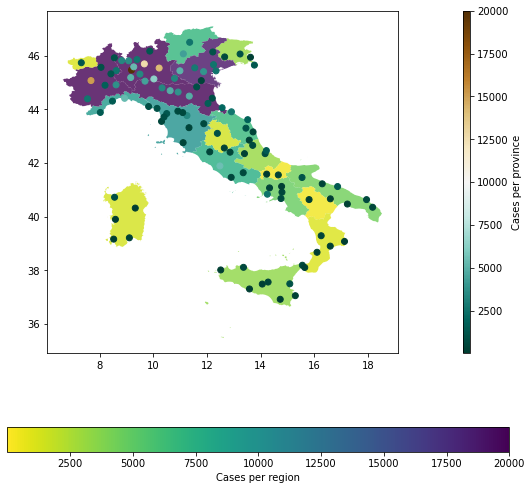

In [24]:
### ABDULLAH ###



from mpl_toolkits.axes_grid1 import make_axes_locatable

fig,ax= plt.subplots(figsize=(9,9))
#ax.set_facecolor('black') 

divider = make_axes_locatable(ax)
cax_province = divider.append_axes("right", size="2%", pad=0.9)

# Region
map_df.plot(ax=ax, alpha=0.8,            
            column='totale_casi', 
            cmap='viridis_r', 
            legend=True,
            vmin=1, 
            vmax=20000,
            legend_kwds={'label': "Cases per region",
                         'orientation': "horizontal"})
# Province
geo_df.plot(ax=ax, column='totale_casi', cmap='BrBG_r', 
            facecolor="none", 
            edgecolors=None, 
            legend=True,
            vmin=1, 
            vmax=20000,
            cax=cax_province,
            legend_kwds={'label': "Cases per province"})